In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Set up models for edge or weight masking

# ## Workflow:
# - Load model
# - Use Task with clean and corrupt data, use ACDCPP and get the ACDCPP-style edges
# - Convert ACDCPP-style edges to edge mask, get either edge superset of node superset
# - Apply these masks to the mask training, either by limiting edge mask to only edge superset, node superset, or by limiting weight mask to node superset
# 
# - Also need to test other baselines, like regular finetuning

# In[1]:


import os
import sys
import pickle
sys.path.append('acdcpp/Automatic-Circuit-Discovery/')
sys.path.append('acdcpp/')
from acdc import TLACDCExperiment
from acdcpp.ACDCPPExperiment import ACDCPPExperiment
import os
import sys
import re

from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.acdc_utils import TorchIndex, EdgeType
import numpy as np
import torch as t
from torch import Tensor
import einops
import itertools
from transformer_lens import HookedTransformer, ActivationCache
import tqdm.notebook as tqdm
import plotly
from rich import print as rprint
from rich.table import Table
from jaxtyping import Float, Bool
from typing import Callable, Tuple, Union, Dict, Optional
import torch

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')
from ACDCPPExperiment import ACDCPPExperiment
from cb_utils.mask_utils import get_masks_from_acdcpp_exp


# In[3]:

import json
import argparse
import os

# Create the parser
# parser = argparse.ArgumentParser(description="Set model parameters")

# # Add the arguments
# parser.add_argument('--config_dir', type=str, required=True, help='Path to the directory with configuration file')

# # Parse the arguments
# args = parser.parse_args()


Device: cuda


In [2]:

# Load the configuration file
# config_dir = "masks/induction_copy/weight_masks_localize=ct"
config_dir = "masks/induction_copy/edge_masks_localize=acdcpp"
with open(config_dir+"/config.json", 'r') as f:
    config = json.load(f)

# Now you can use these arguments in your code
edge_masks = config.get('edge_masks', False)
weight_masks_attn = config.get('weight_masks_attn', False)
weight_masks_mlp = config.get('weight_masks_mlp', False)
train_base_weights = config.get('train_base_weights', False)
localize_acdcpp = config.get('localize_acdcpp', False)
localize_ct = config.get('localize_ct', False)

assert not (localize_acdcpp and localize_ct), "Cannot localize with both acdcpp and ct"

# localization_method = config.get('localization_method', None)
# assert "acdcpp" == localization_method or 
localize_task = config.get('localize_task', "induction")

use_uniform = config.get('use_uniform', False)
uniform_type = config.get('uniform_type', "all_tokens")
unlrn_task_weight = config.get('unlrn_task_weight', -0.2)
epochs_left = config.get('epochs_left', 200)
steps_per_epoch = config.get('steps_per_epoch', 20)
accum_grad_steps = config.get('accum_grad_steps', 1)
lr = config.get('lr', 1e-4)
weight_decay = config.get('weight_decay', 0)
evaluate_every = config.get('evaluate_every', 2)
discretize_every = config.get('discretize_every', 40)
threshold = config.get('threshold', 0.5)
use_wandb = config.get('use_wandb', True)
edge_mask_reg_strength = config.get('edge_mask_reg_strength', 100)
weight_mask_reg_strength = config.get('weight_mask_reg_strength', 100)
num_eval_steps = config.get('num_eval_steps', 10)
save_every = config.get('save_every', None)
# For 'save_path', since the default is not provided in the JSON, assuming None as default
save_path = config.get('save_path', None)
save_efficient = config.get('save_efficient', True)
# Assuming 'scale_reg_strength' is also a parameter you want to load with a default value
scale_reg_strength = config.get('scale_reg_strength', False)
localization_dir_path = config.get('localization_dir_path', None)
# If save_path is None, set it to the directory of the config file
if config['save_path'] is None:
    save_path = config_dir + f"/ckpts"

if localization_dir_path is None:
    localization_method = None
    if localize_acdcpp:
        localization_method = "acdcpp"
    elif localize_ct:
        localization_method = "ct"
    localization_dir_path = f"localizations/{localize_task}/{localization_method}/"


# In[3.5]


if localize_acdcpp or localize_ct:
    with open(f"{localization_dir_path}", "rb") as f:
        acdcpp_nodes, acdcpp_edges, acdcpp_mask_dict, acdcpp_weight_mask_attn_dict, acdcpp_weight_mask_mlp_dict = pickle.load(f)

    mask_dict_superset = acdcpp_mask_dict if edge_masks else None
    weight_mask_attn_dict = acdcpp_weight_mask_attn_dict if weight_masks_attn else None
    weight_mask_mlp_dict = acdcpp_weight_mask_mlp_dict if weight_masks_mlp else None
    base_weight_attn_dict = acdcpp_weight_mask_attn_dict if train_base_weights else None
    base_weight_mlp_dict = acdcpp_weight_mask_mlp_dict if train_base_weights else None

else:
    acdcpp_nodes = None
    acdcpp_edges = None
    acdcpp_mask_dict = None
    acdcpp_weight_mask_attn_dict = None
    acdcpp_weight_mask_mlp_dict = None

    mask_dict_superset = None
    weight_mask_attn_dict = None
    weight_mask_mlp_dict = None
    base_weight_attn_dict = None
    base_weight_mlp_dict = None


print(acdcpp_edges)
# In[12]:


from cb_utils.transformer import DemoTransformer
from cb_utils.models import load_demo_gpt2, tokenizer
#%%


if edge_masks:
    model = load_demo_gpt2(means=False, edge_mask=True, weight_mask=False,
                       edge_masks=edge_masks, mask_dict_superset=mask_dict_superset)
elif weight_masks_attn or weight_masks_mlp:
    model = load_demo_gpt2(means=False, edge_mask=False, weight_mask=True,
                       weight_masks_attn=weight_masks_attn, weight_masks_mlp=weight_masks_mlp, weight_mask_attn_dict=weight_mask_attn_dict, weight_mask_mlp_dict=weight_mask_mlp_dict)
else:
    model = load_demo_gpt2(means=False, edge_mask=False, weight_mask=False,
                       edge_masks=edge_masks, mask_dict_superset=mask_dict_superset, weight_masks_attn=weight_masks_attn, weight_masks_mlp=weight_masks_mlp, weight_mask_attn_dict=weight_mask_attn_dict, weight_mask_mlp_dict=weight_mask_mlp_dict, train_base_weights=train_base_weights, base_weight_attn_dict=base_weight_attn_dict, base_weight_mlp_dict=base_weight_mlp_dict)

# In[13]:

from tasks import IOITask, SportsTask, OWTTask, IOITask_Uniform, GreaterThanTask, InductionTask, InductionTask_Uniform
batch_size = 80
# sports = SportsTask(batch_size=batch_size*2, tokenizer=tokenizer, device=device)
owt = OWTTask(batch_size=batch_size, tokenizer=tokenizer, device=device, ctx_length=40)
greaterthan = GreaterThanTask(batch_size=batch_size, tokenizer=tokenizer, device=device)
ioi = IOITask(batch_size=batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, nb_templates=4, prompt_type="ABBA")
induction = InductionTask(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15)

if localize_task == "ioi":
    ioi_uniform = IOITask_Uniform(batch_size=batch_size, tokenizer=tokenizer, device=device, uniform_over=uniform_type, nb_templates=4, prompt_type="ABBA")

    ioi_task_2 = IOITask(batch_size=batch_size*2, tokenizer=tokenizer, device=device, nb_templates=1, prompt_type="ABBA", template_start_idx=4) # slightly different template

    ioi_task_3 = IOITask(batch_size=batch_size*2, tokenizer=tokenizer, device=device, nb_templates=1, prompt_type="BABA", template_start_idx=0) # different name format

    # train_tasks = {"ioi": ioi, "owt": owt}
    if use_uniform:
        train_tasks = {"ioi_uniform": ioi_uniform, "owt": owt}
        task_weights = {"ioi_uniform": unlrn_task_weight, "owt": 1} # I think means preserve OWT, corrupt IOI
    else:
        train_tasks = {"ioi": ioi, "owt": owt}
        task_weights = {"ioi": unlrn_task_weight, "owt": 1}

    eval_tasks = {"ioi": ioi, "induction": induction, "owt": owt, "ioi_2": ioi_task_2, "ioi_3": ioi_task_3, "greaterthan": greaterthan}

elif localize_task == "induction":
    induction_uniform = InductionTask_Uniform(batch_size=batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, uniform_over=uniform_type)
    
    if use_uniform:
        train_tasks = {"induction_uniform": induction_uniform, "owt": owt}
        task_weights = {"induction_uniform": unlrn_task_weight, "owt": 1}

    else:
        train_tasks = {"induction": induction, "owt": owt}
        task_weights = {"induction": unlrn_task_weight, "owt": 1}

    eval_tasks = {"ioi": ioi, "induction": induction, "owt": owt, "greaterthan": greaterthan}

# In[14]:

mask_params = []
param_names = []
for name, p in model.named_parameters():
    if p.requires_grad:
        param_names.append(name)
        mask_params.append(p)

print(param_names)

# In[16]:

{((5, 'm5'), (5, 'a5.5')), ((7, 'a7.6'), (5, 'a5.9')), ((12, 'output'), (10, 'a10.0')), ((7, 'a7.6'), (6, 'a6.9')), ((12, 'output'), (11, 'a11.8')), ((6, 'm6'), (5, 'a5.1')), ((12, 'output'), (7, 'a7.2')), ((0, 'a0.1'), (-1, 'embed')), ((12, 'output'), (11, 'm11')), ((12, 'output'), (10, 'a10.1')), ((12, 'output'), (7, 'm7')), ((12, 'output'), (9, 'a9.6')), ((11, 'm11'), (11, 'a11.8')), ((12, 'output'), (7, 'a7.10')), ((12, 'output'), (9, 'm9')), ((12, 'output'), (10, 'a10.7')), ((12, 'output'), (9, 'a9.9')), ((7, 'a7.6'), (6, 'a6.6')), ((12, 'output'), (11, 'a11.9')), ((7, 'a7.6'), (5, 'a5.5')), ((11, 'm11'), (9, 'm9')), ((12, 'output'), (11, 'a11.10')), ((12, 'output'), (10, 'm10')), ((7, 'a7.6'), (5, 'a5.1')), ((12, 'output'), (6, 'a6.9'))}
Using device: cuda:0
Loaded edge-masked transformer


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


['output_mask', 'blocks.0.edge_mask_attentions', 'blocks.0.edge_mask_mlp', 'blocks.1.edge_mask_attentions', 'blocks.1.edge_mask_mlp', 'blocks.2.edge_mask_attentions', 'blocks.2.edge_mask_mlp', 'blocks.3.edge_mask_attentions', 'blocks.3.edge_mask_mlp', 'blocks.4.edge_mask_attentions', 'blocks.4.edge_mask_mlp', 'blocks.5.edge_mask_attentions', 'blocks.5.edge_mask_mlp', 'blocks.6.edge_mask_attentions', 'blocks.6.edge_mask_mlp', 'blocks.7.edge_mask_attentions', 'blocks.7.edge_mask_mlp', 'blocks.8.edge_mask_attentions', 'blocks.8.edge_mask_mlp', 'blocks.9.edge_mask_attentions', 'blocks.9.edge_mask_mlp', 'blocks.10.edge_mask_attentions', 'blocks.10.edge_mask_mlp', 'blocks.11.edge_mask_attentions', 'blocks.11.edge_mask_mlp']


In [3]:
tot_0s = 0
tot_1s = 0
for param in mask_params:
    tot_0s += (param == 0).sum()
    tot_1s += (param == 1).sum()
print(tot_0s, tot_1s)

tensor(0, device='cuda:0') tensor(11611, device='cuda:0')


In [4]:

from cb_utils.learn_mask import train_masks

# wandb_config = {
#     "edge_masks": edge_masks, "weight_masks_attn": weight_masks_attn, "weight_masks_mlp": weight_masks_mlp,  "train_base_weights": train_base_weights, "localize_acdcpp": localize_acdcpp, "localize_task": localize_task,
#     "uniform_type": uniform_type, "unlrn_task_weight": unlrn_task_weight, "use_uniform": use_uniform, 
#     "epochs": epochs_left, "steps_per_epoch": steps_per_epoch, "lr": lr, "weight_decay": weight_decay, "evaluate_every": evaluate_every, "discretize_every": discretize_every, "threshold": threshold, "edge_mask_reg_strength": edge_mask_reg_strength, "weight_mask_reg_strength": weight_mask_reg_strength}
# set wandb_config to config
wandb_config = config

if scale_reg_strength:
    orig_edge_mask_reg_strength = edge_mask_reg_strength
    orig_weight_mask_reg_strength = weight_mask_reg_strength
    edge_mask_reg_strength = lambda epoch: orig_edge_mask_reg_strength * (epoch - 20)
    weight_mask_reg_strength = lambda epoch: orig_weight_mask_reg_strength * (epoch - 20)

optimizer = torch.optim.AdamW(mask_params, lr=lr, weight_decay=weight_decay)
train_losses, test_losses = train_masks(model, tasks=train_tasks, optimizer=optimizer, num_epochs=epochs_left, steps_per_epoch=steps_per_epoch, accum_grad_steps=accum_grad_steps,
            # param_names=param_names, mask_params=mask_params, 
            task_weights=task_weights, eval_tasks=eval_tasks, evaluate_every=evaluate_every, discretize_every=discretize_every, save_every=save_every,
            threshold=threshold, edge_mask_reg_strength=edge_mask_reg_strength, weight_mask_reg_strength=weight_mask_reg_strength, verbose=False, use_wandb=use_wandb, wandb_config=wandb_config, save_dir=save_path, save_efficient=save_efficient)


# In[17]:


# import pickle
# # with open(f"masks/trained_mask_params_{epochs_left=}_{edge_mask_reg_strength=}_{uniform_type=}/final_params.pkl", "wb") as f:
# # with open(f"{save_path}/final_params.pkl", "wb") as f:
# #     pickle.dump(mask_params, f)
# os.makedirs(save_path, exist_ok=True)
# if save_efficient:
#     model_path = f"{save_path}/mask_params_final.pkl"
#     with open(model_path, "wb") as f:
#         pickle.dump((param_names, mask_params), f)
# else:
#     model_path = f"{save_path}/mask_params_final.pth"
#     torch.save(model.state_dict(), model_path)

# with open(f"{save_path}/final_losses.pkl", "wb") as f:
#     pickle.dump((train_losses, test_losses), f)

# In[18]:


wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


100%|██████████| 51/51 [03:49<00:00,  4.50s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


edge_reg_term,██▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇██████
num_ablated_edges,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
num_ablated_weights,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss_greaterthan,██▁███▁▁█▁███
test_loss_greaterthan_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss_greaterthan_logit_diff,▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss_induction,▃▃▇▃▁▃▂▆▅▁█▃▃
test_loss_induction_acc,▅██▅▅███▁████
test_loss_induction_logit_diff,▄▄▃▁▂▄▅▂▃▂▂▆█
test_loss_ioi,▄▂▆▅▆▅▃█▃▇▇▁▆
test_loss_ioi_acc,▅▅▁█▅███▅█▅▁█


In [11]:
train_losses.keys()

dict_keys(['induction_uniform', 'owt', 'edge_reg_term', 'weight_mask_reg', 'edge_mask_reg', 'weight_mask_regs'])

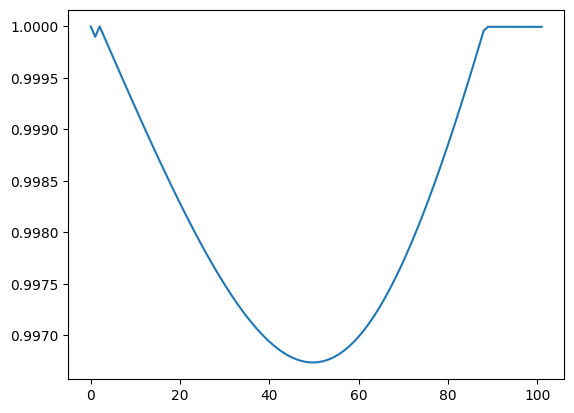

In [12]:
from matplotlib import pyplot as plt
# weight_mask_regs = [x[2].item() for x in train_losses["weight_mask_reg"]]
# plt.plot(weight_mask_regs)
edge_mask_regs = [x[2].item() for x in train_losses["edge_reg_term"]]
plt.plot(edge_mask_regs)
plt.show()

In [13]:
for name, p in zip(param_names, mask_params):
    if p.requires_grad:
        # print(name, p)
        # count how many zeros in p
        print(name, (p == 0).sum(), (p == 1).sum())



output_mask tensor(0, device='cuda:0') tensor(157, device='cuda:0')
blocks.0.edge_mask_attentions tensor(0, device='cuda:0') tensor(12, device='cuda:0')
blocks.0.edge_mask_mlp tensor(0, device='cuda:0') tensor(13, device='cuda:0')
blocks.1.edge_mask_attentions tensor(0, device='cuda:0') tensor(168, device='cuda:0')
blocks.1.edge_mask_mlp tensor(0, device='cuda:0') tensor(26, device='cuda:0')
blocks.2.edge_mask_attentions tensor(0, device='cuda:0') tensor(324, device='cuda:0')
blocks.2.edge_mask_mlp tensor(0, device='cuda:0') tensor(39, device='cuda:0')
blocks.3.edge_mask_attentions tensor(0, device='cuda:0') tensor(480, device='cuda:0')
blocks.3.edge_mask_mlp tensor(0, device='cuda:0') tensor(52, device='cuda:0')
blocks.4.edge_mask_attentions tensor(0, device='cuda:0') tensor(636, device='cuda:0')
blocks.4.edge_mask_mlp tensor(0, device='cuda:0') tensor(65, device='cuda:0')
blocks.5.edge_mask_attentions tensor(0, device='cuda:0') tensor(792, device='cuda:0')
blocks.5.edge_mask_mlp tens